## 기존 코드

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Wav2Vec2Model is using Wav2Vec2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Number of transformer layers: 12
Shape of attention in layer[0]: torch.Size([1, 12, 104, 104])
Layer 0 Head similarity matrix:
tensor([[1.0000, 0.5070, 0.3319, 0.7796, 0.4790, 0.6825, 0.5391, 0.5138, 0.5003,
         0.6340, 0.5519, 0.4513],
        [0.5070, 1.0000, 0.3395, 0.4465, 0.6803, 0.3816, 0.4717, 0.6596, 0.6410,
         0.4529, 0.6734, 0.6936],
        [0.3319, 0.3395, 1.0000, 0.2997, 0.4923, 0.4017, 0.3289, 0.4171, 0.3916,
         0.3559, 0.4870, 0.3378],
        [0.7796, 0.4465, 0.2997, 1.0000, 0.4260, 0.7351, 0.5750, 0.5273, 0.5102,
         0.7029, 0.5054, 0.3698],
        [0.4790, 0.6803, 0.4923, 0.4260, 1.0000, 0.4025, 0.4391, 0.6571, 0.5709,
         0.5232, 0.7314, 0.7427],
        [0.6825, 0.3816, 0.4017, 0.7351, 0.4025, 1.0000, 0.5427, 0.4361, 0.4018,
         0.6598, 0.5422, 0.3143],
        [0.5391, 0.4717, 0.3289, 0.5750, 0.4391, 0.5427, 1.0000, 0.4845, 0.4177,
         0.5117, 0.5048, 0.4153],
        [0.5138, 0.6596, 0.4171, 0.5273, 0.6571, 0.4361, 0.4845, 1.0

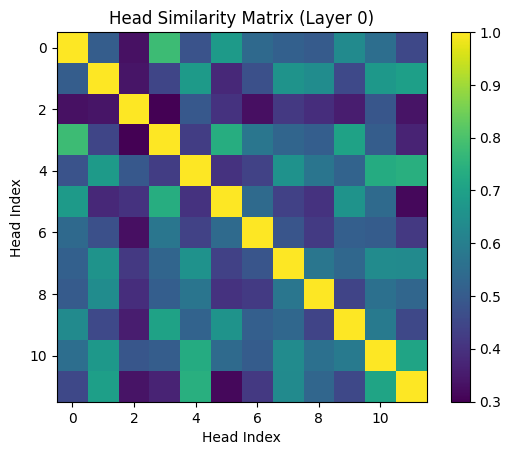

Layer 0 - Average off-diagonal Head similarity: 0.5186
Layer 1 - Average off-diagonal Head similarity: 0.4016
Layer 2 - Average off-diagonal Head similarity: 0.5452
Layer 3 - Average off-diagonal Head similarity: 0.5429
Layer 4 - Average off-diagonal Head similarity: 0.4283
Layer 5 - Average off-diagonal Head similarity: 0.5993
Layer 6 - Average off-diagonal Head similarity: 0.6580
Layer 7 - Average off-diagonal Head similarity: 0.6734
Layer 8 - Average off-diagonal Head similarity: 0.6178
Layer 9 - Average off-diagonal Head similarity: 0.5313
Layer 10 - Average off-diagonal Head similarity: 0.5400
Layer 11 - Average off-diagonal Head similarity: 0.4638


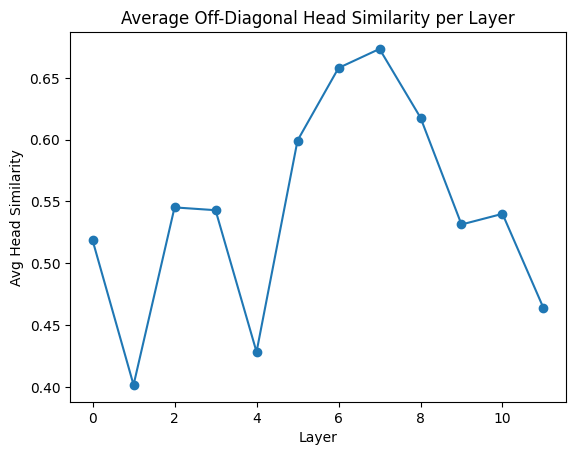

In [ ]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# 1. 모델과 프로세서 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")

# 모델을 evaluation 모드로 전환
model.eval()

# 2. 예시 오디오 파일 불러오기 (16kHz 모노 채널 권장).
#    만약 실제 음성 파일이 없다면 dummy tensor를 이용할 수도 있습니다.
#    아래는 librosa로 예시 파일을 불러오는 코드입니다.
audio_filepath = "/home/kobie/workspace/data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"  # 실제 파일 경로로 수정
waveform, sr = librosa.load(audio_filepath, sr=16000, mono=True)

# 3. 입력 전처리
input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values

# 4. Attention 출력을 받기 위해 forward 시 output_attentions=True 설정
with torch.no_grad():
    outputs = model(
        input_values, 
        output_attentions=True  # <-- Multi-Head Attention 가중치를 반환
    )

# 5. 각 레이어별 Attention(=outputs.attentions)은 리스트 형태로 반환됩니다.
#    len(outputs.attentions) = num_hidden_layers (Wav2Vec2-base의 경우 12)
#    각 요소 shape = (batch_size, num_heads, seq_len, seq_len)
attentions = outputs.attentions

print(f"Number of transformer layers: {len(attentions)}") # 12
print(f"Shape of attention in layer[0]: {attentions[0].shape}") # [1, 12, 104, 104]

# 6. Head 간 redundancy를 살펴보기 위한 간단한 함수 예시
#    여기서는 'attention matrix'를 펼친 뒤 헤드 간 코사인 유사도를 계산해 봅니다.
def compute_head_redundancy(att_mats):
    """
    att_mats: 텐서 shape = (num_heads, seq_len, seq_len)
    return:   head 간 유사도 행렬, shape = (num_heads, num_heads)
    """
    num_heads = att_mats.size(0)
    seq_len = att_mats.size(1)
    
    # (num_heads, seq_len*seq_len)으로 reshape
    att_reshaped = att_mats.view(num_heads, -1)
    
    # 코사인 유사도 계산
    # 유클리디안 노름
    norm = att_reshaped.norm(dim=1, keepdim=True)  # shape = (num_heads, 1)
    att_normed = att_reshaped / (norm + 1e-9)

    # (num_heads, num_heads) = att_normed @ att_normed.T
    similarity_matrix = att_normed @ att_normed.transpose(0, 1)
    return similarity_matrix

# 7. 예시로 첫 번째 레이어의 Head들 간 유사도를 계산해보고 시각화
layer_idx = 0
att_mat = attentions[layer_idx][0]  # batch_size=1 가정 => (num_heads, seq_len, seq_len)
similarity = compute_head_redundancy(att_mat)

print(f"Layer {layer_idx} Head similarity matrix:\n{similarity}")

# 8. 시각화(Heatmap) 예시
plt.imshow(similarity.cpu().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title(f"Head Similarity Matrix (Layer {layer_idx})")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

# 9. 전 레이어에 대해 평균적인 redundancy를 보는 간단한 예시
#    레이어별 모든 Head 쌍 간의 평균 코사인 유사도를 출력
all_layer_sims = []

for l_idx, att in enumerate(attentions):
    # att shape = (batch_size, num_heads, seq_len, seq_len)
    # 여기서는 batch_size=1 가정
    att_mat = att[0]  
    sim_matrix = compute_head_redundancy(att_mat)
    # Head 쌍별 평균
    mean_sim = (sim_matrix.sum() - sim_matrix.diag().sum()) / (sim_matrix.numel() - sim_matrix.size(0))
    all_layer_sims.append(mean_sim.item())

    print(f"Layer {l_idx} - Average off-diagonal Head similarity: {mean_sim.item():.4f}")

# 10. 레이어별 유사도를 간단히 그래프로 표시
plt.plot(range(len(all_layer_sims)), all_layer_sims, marker='o')
plt.title("Average Off-Diagonal Head Similarity per Layer")
plt.xlabel("Layer")
plt.ylabel("Avg Head Similarity")
plt.show()


In [2]:
len(attentions) # 12

attentions[0].shape # torch.Size([1, 12, 104, 104])  (batch_size, num_heads, seq_len, seq_len)



torch.Size([1, 12, 104, 104])

## On Attention Redundancy 논문 구현 함수

In [22]:
import torch
import numpy as np
from scipy.special import softmax
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# =============== #
# 1. 모델 로드 예시
# =============== #
# 요청에 따라 Wav2Vec2 모델과 프로세서를 예시로 로드합니다.
# (실제로는 BERT에서 attention을 추출해야 하므로, BERT 모델을 사용해야 함)
from transformers import Wav2Vec2Processor, Wav2Vec2Model

def cosine_distance(vec1, vec2):
    """1 - cosine similarity"""
    # scipy의 cosine()는 distance를 바로 반환하므로 그대로 사용해도 됨
    # distance = 1 - cosine_similarity => distance = cosine_distance
    return cosine(vec1, vec2)

def pearson_distance(vec1, vec2):
    """1 - Pearson correlation"""
    # stats.pearsonr 리턴값: (상관계수, p-value)
    corr, _ = pearsonr(vec1, vec2)
    # corr 범위는 -1 ~ 1, 거리로 쓰려면 [0,2] 범위가 되지만
    # 논문에서 0~1로 표준화한다고 했으니 1 - (corr+1)/2 로 매핑하는 식도 고려할 수 있음
    # 여기서는 간단히 1 - corr로만 사용(음의 상관도 처리 방법은 연구 맥락에 따라 달라짐)
    return 1 - corr

def jensen_shannon_distance(p, q):
    """Jensen-Shannon distance (보통 JS divergence의 제곱근을 distance로 사용)"""
    # 두 확률 분포 p, q가 들어온다고 가정 (합이 1)
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    # KL 계산 시 log(0) 방지를 위해 epsilon 추가 등 처리 가능
    def kl_div(a, b):
        a = np.where(a == 0, 1e-12, a)
        b = np.where(b == 0, 1e-12, b)
        return np.sum(a * np.log(a / b))
    js_div = 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)
    return np.sqrt(js_div)  # JS distance

def bhattacharyya_distance(p, q):
    """Bhattacharyya distance"""
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    p /= p.sum()
    q /= q.sum()
    bc = np.sum(np.sqrt(p * q))
    # Bhattacharyya distance = -ln(bc)
    # 보통 0~∞ 범위, 논문에서는 [0,1] 범위로 정규화해서 사용
    # 여기서는 간단히 -ln(bc)만 반환, 필요 시 max/min 스케일링 가능
    return -np.log(bc + 1e-12)

def get_token_based_distance(matA, matB, metric="cosine"):
    """
    matA, matB shape = (seq_len, seq_len)
    각각의 '행(row)'을 해당 토큰(i)이 바라보는 attention distribution이라 가정.
    토큰 i마다 vecA = matA[i, :], vecB = matB[i, :]
    -> 두 벡터 간 distance 측정 -> 전체 토큰에 대해 평균.
    """
    distances = []
    for i in range(matA.shape[0]):
        vecA = matA[i, :]
        vecB = matB[i, :]

        if metric == "cosine":
            dist = cosine_distance(vecA, vecB)
        elif metric == "corr":
            dist = pearson_distance(vecA, vecB)
        elif metric == "js":
            dist = jensen_shannon_distance(vecA, vecB)
        elif metric == "bc":
            dist = bhattacharyya_distance(vecA, vecB)
        else:
            raise ValueError("Unknown token-based metric")
        
        distances.append(dist)

    return np.mean(distances)


# =============== #
# 4. Sentence-based distance 함수들
# =============== #
# 두 헤드의 n×n Attention matrix를 “전체 행렬” 단위로 비교해 거리를 구합니다.
# 실제 논문에서 쓰는 distance correlation, Procrustes, Canonical correlation은
# 구현이 조금 복잡하거나 추가 라이브러리가 필요합니다.
# 여기서는 간단한 버전/흉내를 보여드립니다.

def distance_correlation(A, B):
    """
    Distance correlation(Szekely 등)은 임의 차원 행렬 간 독립성/종속성을
    측정하기 위한 지표. 여기서는 간단화를 위해 행렬을 1D로 펼쳐서
    pairwise distance 기반 계산을 아주 간단히 흉내만 낸 예시입니다.
    실제 구현은 더 복잡한 절차가 필요합니다.
    """
    # 실제론 pairwise distance행렬 a_{ij}, b_{ij}를 만들어
    # double-centering 등을 거쳐 계산함.
    # 여기서는 예시로 임시 변환(행렬->1D벡터) 후 상관계수로 대체.
    A_flat = A.flatten()
    B_flat = B.flatten()
    corr, _ = pearsonr(A_flat, B_flat)
    # distance = 1 - |corr|
    # (실제 distance correlation과 동일하진 않지만, 예시로서...)
    return 1 - abs(corr)

def procrustes_distance(A, B):
    """
    Procrustes analysis:
    한 행렬을 회전/축척/직교변환하여 다른 행렬과 얼마나 잘 align되는지 보는 기법.
    실제론 scipy의 procrustes 등을 사용할 수 있음.
    여기서는 매우 단순화된 예시(행렬을 정규화해 차이만 보는 형태).
    """
    # 간단히 frobenius norm으로 차이를 보는 예시
    # 실제론 회전/직교 변환 등을 최적화로 구해야 함.
    A_norm = A / (np.linalg.norm(A) + 1e-12)
    B_norm = B / (np.linalg.norm(B) + 1e-12)
    fro_diff = np.linalg.norm(A_norm - B_norm)
    # fro_diff 범위가 [0,2] 정도 되므로, 0~1 사이로 스케일링하기 위해 /2
    return fro_diff / 2.0

def canonical_correlation_distance(A, B):
    """
    Canonical Correlation: 두 데이터 집합(행렬)의 선형 조합들이
    얼마나 상관관계가 높은지 측정하는 기법.
    실제론 차원 맞춤, SVD 등을 이용해야 함.
    여기서는 간단히 SVD 없이 열벡터를 이어 붙인 후 상관관계로 예시 대체.
    """
    # 예시로 (seq_len x seq_len)을 (seq_len^2)로 펴서 상관 계산
    A_flat = A.flatten()
    B_flat = B.flatten()
    corr, _ = pearsonr(A_flat, B_flat)
    # corr이 높을수록 유사 -> distance = 1 - corr
    return 1 - corr

def get_sentence_based_distance(matA, matB, metric="dCor"):
    """
    matA, matB shape = (seq_len, seq_len)
    한 문장 전체의 attention 행렬을 직접 비교.
    """
    if metric == "dCor":
        return distance_correlation(matA, matB)
    elif metric == "PC":
        return procrustes_distance(matA, matB)
    elif metric == "CC":
        return canonical_correlation_distance(matA, matB)
    else:
        raise ValueError("Unknown sentence-based metric")


# =============== #
# 5. 실제 Pairwise Distance 계산 예시
# =============== #
# 여기서는 head가 4개이므로 4x4=16개 쌍에 대해 거리를 구하여
# (4,4) 크기의 distance matrix를 얻을 수 있습니다.

def compute_pairwise_distances(attention_mats, distance_func, mode="token", metric="cosine"):
    """
    attention_mats: shape = (num_heads, seq_len, seq_len)
    distance_func: get_token_based_distance() or get_sentence_based_distance()
    mode: "token" or "sentence"
    metric: 사용할 세부 지표
    """
    num_heads = attention_mats.shape[0]
    dist_matrix = np.zeros((num_heads, num_heads))

    for i in range(num_heads):
        for j in range(num_heads):
            if i == j:
                dist_matrix[i, j] = 0.0
            elif j > i:
                dist_val = distance_func(attention_mats[i], attention_mats[j], metric)
                dist_matrix[i, j] = dist_val
                dist_matrix[j, i] = dist_val
            # j < i인 경우 이미 계산됨

    return dist_matrix

## Attention Map 구하기

In [8]:
# audio_filepath = "/home/kobie/workspace/data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"  # 실제 파일 경로로 수정
audio_filepath = "/home/kobie/workspace/data/LibriSpeech/dev-other/700/122866/700-122866-0000.flac"

In [9]:
from IPython.display import Audio

# 오디오 파일 재생
Audio(audio_filepath)

In [10]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import seaborn as sns


# 1. 모델과 프로세서 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")

# 모델을 evaluation 모드로 전환
model.eval()

# 2. 예시 오디오 파일 불러오기 (16kHz 모노 채널 권장).
#    만약 실제 음성 파일이 없다면 dummy tensor를 이용할 수도 있습니다.
#    아래는 librosa로 예시 파일을 불러오는 코드입니다.

waveform, sr = librosa.load(audio_filepath, sr=16000, mono=True)

# 3. 입력 전처리
input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values

# 4. Attention 출력을 받기 위해 forward 시 output_attentions=True 설정
with torch.no_grad():
    outputs = model(
        input_values, 
        output_attentions=True  # <-- Multi-Head Attention 가중치를 반환
    )

# 5. 각 레이어별 Attention(=outputs.attentions)은 리스트 형태로 반환됩니다.
#    len(outputs.attentions) = num_hidden_layers (Wav2Vec2-base의 경우 12)
#    각 요소 shape = (batch_size, num_heads, seq_len, seq_len)
attentions = outputs.attentions


# batch_size=1이므로 dim=0 없애기
attention_matrices = torch.stack(attentions).squeeze(1) # torch.Size([12, 12, 104, 104])

# (num_heads * num_layers, seq_len, seq_len)으로 변환
seq_len = attention_matrices.shape[-1]
attention_matrices = attention_matrices.view(-1, seq_len, seq_len) # torch.Size([144, 104, 104])



Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
print(f'layer 수 : {len(attentions)}')
print(f'attentions[0].shape : {attentions[0].shape}')


layer 수 : 12
attentions[0].shape : torch.Size([1, 12, 244, 244])


## Redundancy Matrix 생성

### Token-Based - Cosine Distance (cos)

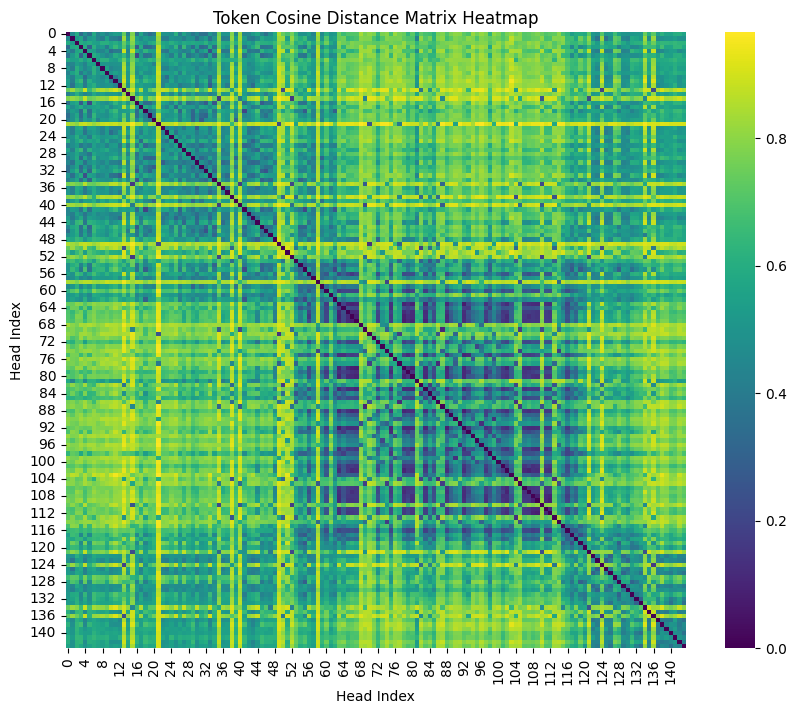

In [ ]:
token_cos_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_token_based_distance,
    mode="token",
    metric="cosine"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap='viridis', annot=False)
plt.title("Token Cosine Distance Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

In [8]:
attentions[0].shape # torch.Size([1, 12, 104, 104])  (batch_size, num_heads, seq_len, seq_len)

torch.Size([1, 12, 244, 244])

### Token-Based - Pearson correlation coefficient (corr)

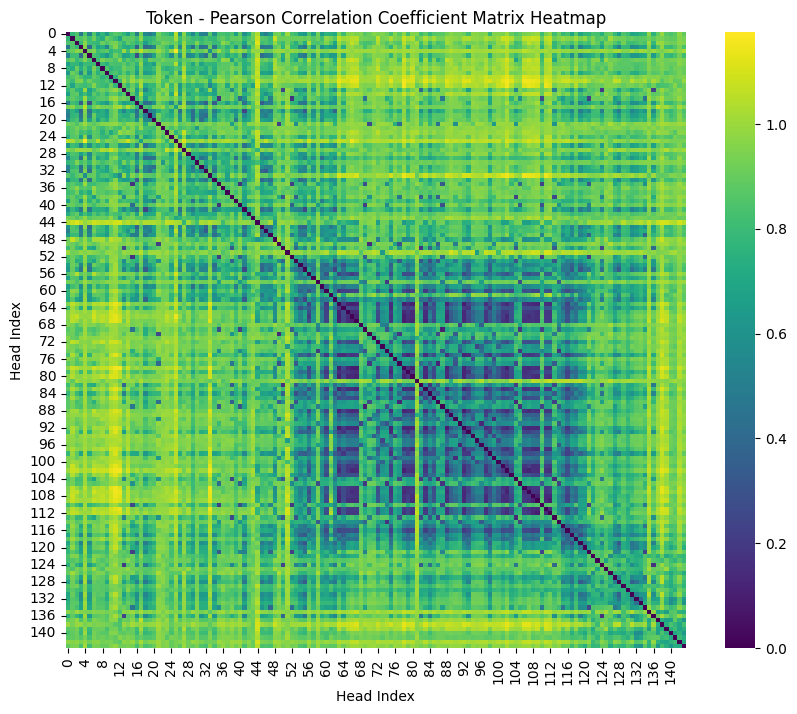

In [9]:
token_corr_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_token_based_distance,
    mode="token",
    metric="corr"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_corr_dist_matrix, cmap='viridis', annot=False)
plt.title("Token - Pearson Correlation Coefficient Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

### Token-Based - Jensen Shannon distance (JS)

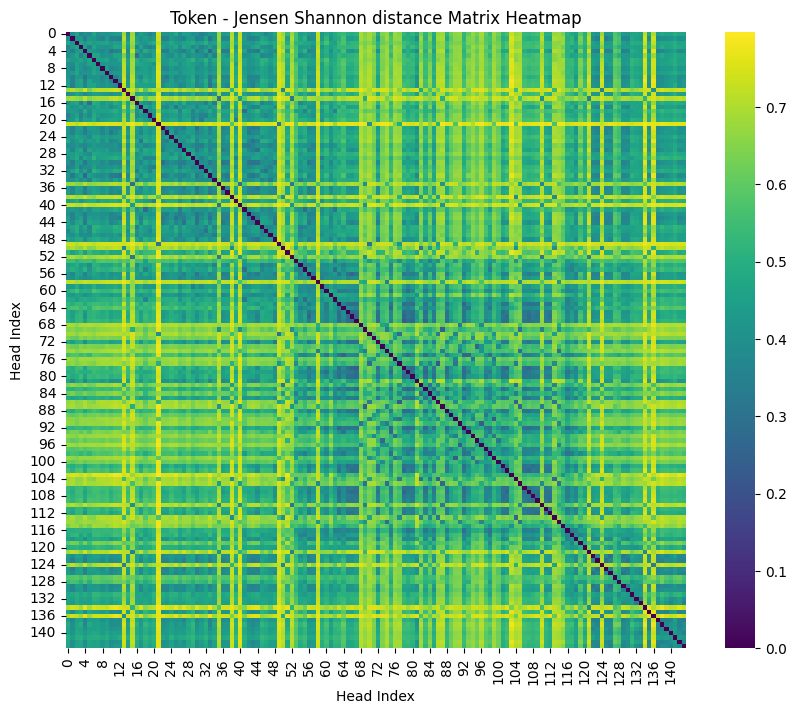

In [10]:
token_js_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_token_based_distance,
    mode="token",
    metric="js"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_js_dist_matrix, cmap='viridis', annot=False)
plt.title("Token - Jensen Shannon distance Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

### Token-Based - Bhattacharyya coefficient (BC)

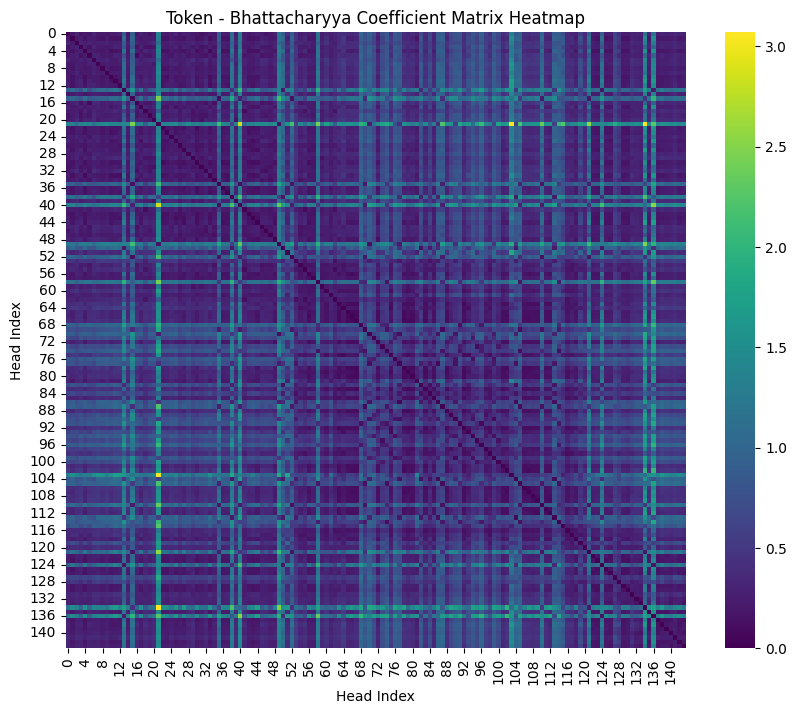

In [11]:
token_bc_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_token_based_distance,
    mode="token",
    metric="bc"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_bc_dist_matrix, cmap='viridis', annot=False)
plt.title("Token - Bhattacharyya Coefficient Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

### Sentence-Based - distance correlation (dCor)

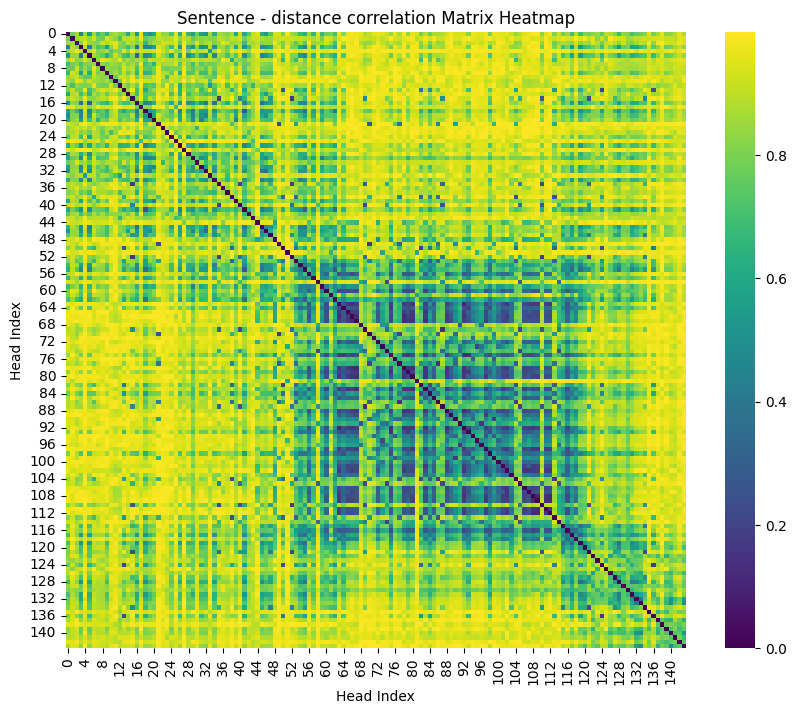

In [12]:
token_dCor_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_sentence_based_distance,
    mode="sentence",
    metric="dCor"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_dCor_dist_matrix, cmap='viridis', annot=False)
plt.title("Sentence - distance correlation Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

### Setence-Based - Procrustes coefficient (PC)

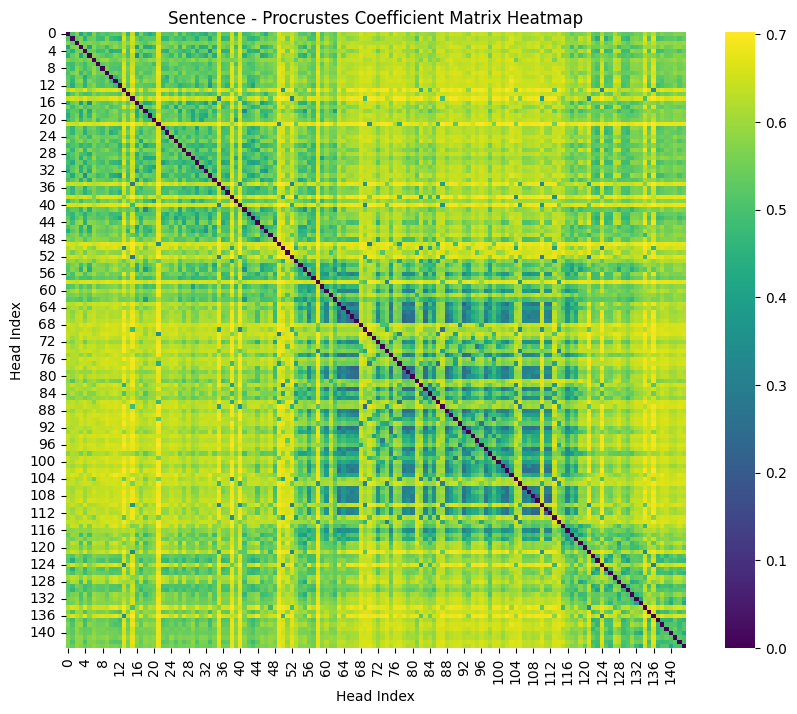

In [13]:
token_PC_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_sentence_based_distance,
    mode="sentence",
    metric="PC"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_PC_dist_matrix, cmap='viridis', annot=False)
plt.title("Sentence - Procrustes Coefficient Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

### Sentence-Based - Canonical correlation (CC)

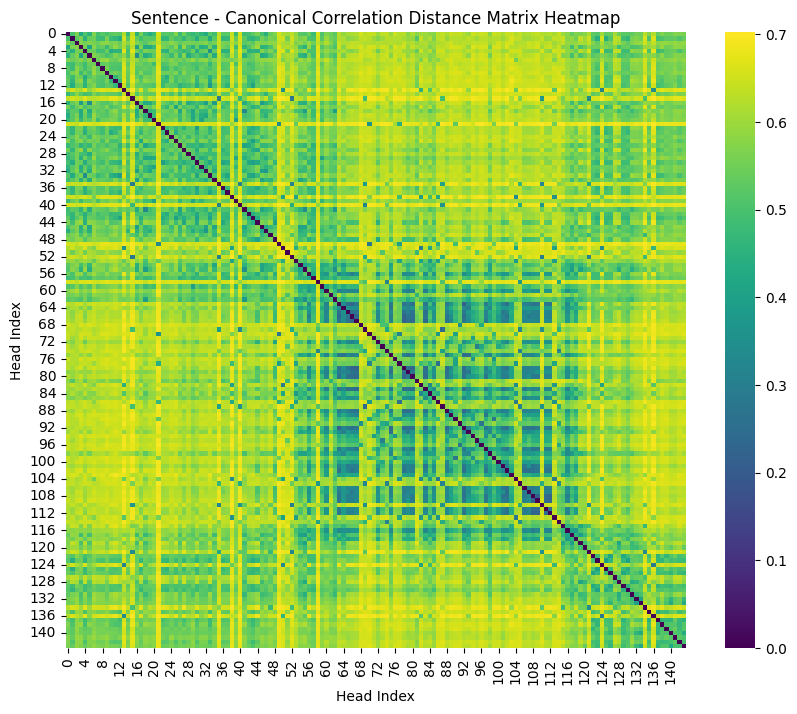

In [14]:
token_CC_dist_matrix = compute_pairwise_distances(
    attention_matrices,
    distance_func=get_sentence_based_distance,
    mode="sentence",
    metric="CC"
)

# Create a heatmap for the token cosine distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(token_PC_dist_matrix, cmap='viridis', annot=False)
plt.title("Sentence - Canonical Correlation Distance Matrix Heatmap")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

## 샘플 수 늘리기

In [30]:
import os

audio_path = "/home/kobie/workspace/data/LibriSpeech/test-other/367/130732" # 오디오 파일이 들어있는 폴더

# 해당 폴더 아래에 있는 음성 파일 경로 리스트로 저장
audio_files = [os.path.join(audio_path, f) for f in os.listdir(audio_path) if f.endswith(".flac")]

print(f'files 수: {len(audio_files)}')
print(f'files: {audio_files[:5]}...')


files 수: 34
files: ['/home/kobie/workspace/data/LibriSpeech/test-other/367/130732/367-130732-0003.flac', '/home/kobie/workspace/data/LibriSpeech/test-other/367/130732/367-130732-0027.flac', '/home/kobie/workspace/data/LibriSpeech/test-other/367/130732/367-130732-0017.flac', '/home/kobie/workspace/data/LibriSpeech/test-other/367/130732/367-130732-0021.flac', '/home/kobie/workspace/data/LibriSpeech/test-other/367/130732/367-130732-0000.flac']...


In [31]:
import os
import torch
import librosa
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# 1. 모델과 프로세서 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")
model.eval()

# 4. 오디오 파일들 불러오기 (16kHz, mono 권장)
waveforms = []
for file in audio_files:
    waveform, sr = librosa.load(file, sr=16000, mono=True)
    waveforms.append(waveform)

# 5. 입력 전처리
#    processor에 리스트 형태의 waveforms를 넣으면 내부적으로 패딩(padding)을 적용하여
#    동일한 길이로 맞춰준 뒤 배치(batch) 텐서를 반환합니다.
input_values = processor(
    waveforms,
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
).input_values  # shape: (batch_size, padded_seq_len)

# 6. 모델 추론 (Attention 가중치 받기 위해 output_attentions=True 설정)
with torch.no_grad():
    outputs = model(
        input_values,
        output_attentions=True
    )

# 7. outputs.attentions는 num_layers 길이의 리스트이며,
#    각 원소는 (batch_size, num_heads, seq_len, seq_len) 형태입니다.
attentions = outputs.attentions

# 예시) 레이어별, 배치별 어텐션 사이즈 확인
for i, attn_layer in enumerate(attentions):
    print(f"Layer {i} attention shape:", attn_layer.shape)  
    # -> (batch_size, num_heads, seq_len, seq_len)

# 레이어 축 합치기
attention_matrices = torch.stack(attentions, dim=0)
print("Stacked attention shape:", attention_matrices.shape)
# -> (num_layers, batch_size, num_heads, seq_len, seq_len)

attention_matrices = attention_matrices.permute(1, 0, 2, 3, 4).contiguous()
attention_matrices = attention_matrices.view(
    attention_matrices.size(0),
    -1,
    attention_matrices.size(3),
    attention_matrices.size(4)
)
print("Reshaped attention shape:", attention_matrices.shape)
# -> (batch_size, num_layers * num_heads, seq_len, seq_len)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer 0 attention shape: torch.Size([34, 12, 925, 925])
Layer 1 attention shape: torch.Size([34, 12, 925, 925])
Layer 2 attention shape: torch.Size([34, 12, 925, 925])
Layer 3 attention shape: torch.Size([34, 12, 925, 925])
Layer 4 attention shape: torch.Size([34, 12, 925, 925])
Layer 5 attention shape: torch.Size([34, 12, 925, 925])
Layer 6 attention shape: torch.Size([34, 12, 925, 925])
Layer 7 attention shape: torch.Size([34, 12, 925, 925])
Layer 8 attention shape: torch.Size([34, 12, 925, 925])
Layer 9 attention shape: torch.Size([34, 12, 925, 925])
Layer 10 attention shape: torch.Size([34, 12, 925, 925])
Layer 11 attention shape: torch.Size([34, 12, 925, 925])
Stacked attention shape: torch.Size([12, 34, 12, 925, 925])
Reshaped attention shape: torch.Size([34, 144, 925, 925])


Mean over batch shape: torch.Size([144, 925, 925])


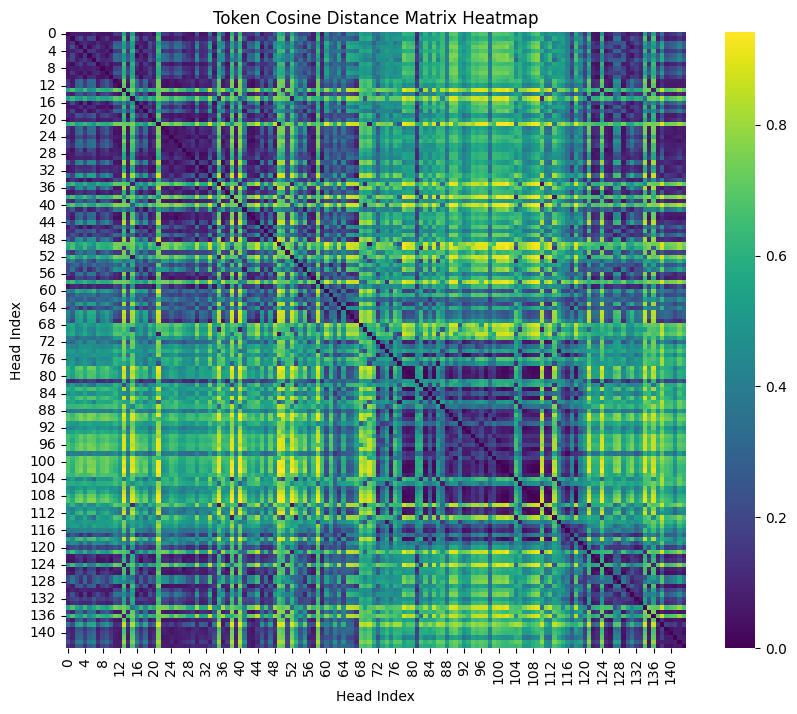

In [32]:
# 11. batch 차원(=dim=0)에 대해 평균 -> (num_layers * num_heads, seq_len, seq_len)
attention_matrices_mean = attention_matrices.mean(dim=0)
print("Mean over batch shape:", attention_matrices_mean.shape)
# -> (num_layers * num_heads, seq_len, seq_len)

# 12. pairwise distance 계산
token_cos_dist_matrix = compute_pairwise_distances(
    attention_matrices_mean,
    distance_func=get_token_based_distance,
    mode="token",
    metric="cosine"
)

# 13. 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap='viridis', annot=False)
plt.title("Token Cosine Distance Matrix Heatmap")
plt.xlabel("Head Index")     # num_layers * num_heads 개수만큼의 Head Index(실제론 layer-head)
plt.ylabel("Head Index")
plt.show()

# Interspeech 2025 제출을 위한 Figure 1 재생성

In [ ]:
import torch
import numpy as np
from scipy.special import softmax
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import seaborn as sns

# =============== #
# 1. 모델 로드 예시
# =============== #
# 요청에 따라 Wav2Vec2 모델과 프로세서를 예시로 로드합니다.
# (실제로는 BERT에서 attention을 추출해야 하므로, BERT 모델을 사용해야 함)
from transformers import Wav2Vec2Processor, Wav2Vec2Model

def cosine_distance(vec1, vec2):
    """1 - cosine similarity"""
    # scipy의 cosine()는 distance를 바로 반환하므로 그대로 사용해도 됨
    # distance = 1 - cosine_similarity => distance = cosine_distance
    return cosine(vec1, vec2)

def pearson_distance(vec1, vec2):
    """1 - Pearson correlation"""
    # stats.pearsonr 리턴값: (상관계수, p-value)
    corr, _ = pearsonr(vec1, vec2)
    # corr 범위는 -1 ~ 1, 거리로 쓰려면 [0,2] 범위가 되지만
    # 논문에서 0~1로 표준화한다고 했으니 1 - (corr+1)/2 로 매핑하는 식도 고려할 수 있음
    # 여기서는 간단히 1 - corr로만 사용(음의 상관도 처리 방법은 연구 맥락에 따라 달라짐)
    return 1 - corr

def jensen_shannon_distance(p, q):
    """Jensen-Shannon distance (보통 JS divergence의 제곱근을 distance로 사용)"""
    # 두 확률 분포 p, q가 들어온다고 가정 (합이 1)
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    # KL 계산 시 log(0) 방지를 위해 epsilon 추가 등 처리 가능
    def kl_div(a, b):
        a = np.where(a == 0, 1e-12, a)
        b = np.where(b == 0, 1e-12, b)
        return np.sum(a * np.log(a / b))
    js_div = 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)
    return np.sqrt(js_div)  # JS distance

def bhattacharyya_distance(p, q):
    """Bhattacharyya distance"""
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    p /= p.sum()
    q /= q.sum()
    bc = np.sum(np.sqrt(p * q))
    # Bhattacharyya distance = -ln(bc)
    # 보통 0~∞ 범위, 논문에서는 [0,1] 범위로 정규화해서 사용
    # 여기서는 간단히 -ln(bc)만 반환, 필요 시 max/min 스케일링 가능
    return -np.log(bc + 1e-12)

def get_token_based_distance(matA, matB, metric="cosine"):
    """
    matA, matB shape = (seq_len, seq_len)
    각각의 '행(row)'을 해당 토큰(i)이 바라보는 attention distribution이라 가정.
    토큰 i마다 vecA = matA[i, :], vecB = matB[i, :]
    -> 두 벡터 간 distance 측정 -> 전체 토큰에 대해 평균.
    """
    distances = []
    for i in range(matA.shape[0]):
        vecA = matA[i, :]
        vecB = matB[i, :]

        if metric == "cosine":
            dist = cosine_distance(vecA, vecB)
        elif metric == "corr":
            dist = pearson_distance(vecA, vecB)
        elif metric == "js":
            dist = jensen_shannon_distance(vecA, vecB)
        elif metric == "bc":
            dist = bhattacharyya_distance(vecA, vecB)
        else:
            raise ValueError("Unknown token-based metric")
        
        distances.append(dist)

    return np.mean(distances)


# =============== #
# 4. Sentence-based distance 함수들
# =============== #
# 두 헤드의 n×n Attention matrix를 “전체 행렬” 단위로 비교해 거리를 구합니다.
# 실제 논문에서 쓰는 distance correlation, Procrustes, Canonical correlation은
# 구현이 조금 복잡하거나 추가 라이브러리가 필요합니다.
# 여기서는 간단한 버전/흉내를 보여드립니다.

def distance_correlation(A, B):
    """
    Distance correlation(Szekely 등)은 임의 차원 행렬 간 독립성/종속성을
    측정하기 위한 지표. 여기서는 간단화를 위해 행렬을 1D로 펼쳐서
    pairwise distance 기반 계산을 아주 간단히 흉내만 낸 예시입니다.
    실제 구현은 더 복잡한 절차가 필요합니다.
    """
    # 실제론 pairwise distance행렬 a_{ij}, b_{ij}를 만들어
    # double-centering 등을 거쳐 계산함.
    # 여기서는 예시로 임시 변환(행렬->1D벡터) 후 상관계수로 대체.
    A_flat = A.flatten()
    B_flat = B.flatten()
    corr, _ = pearsonr(A_flat, B_flat)
    # distance = 1 - |corr|
    # (실제 distance correlation과 동일하진 않지만, 예시로서...)
    return 1 - abs(corr)

def procrustes_distance(A, B):
    """
    Procrustes analysis:
    한 행렬을 회전/축척/직교변환하여 다른 행렬과 얼마나 잘 align되는지 보는 기법.
    실제론 scipy의 procrustes 등을 사용할 수 있음.
    여기서는 매우 단순화된 예시(행렬을 정규화해 차이만 보는 형태).
    """
    # 간단히 frobenius norm으로 차이를 보는 예시
    # 실제론 회전/직교 변환 등을 최적화로 구해야 함.
    A_norm = A / (np.linalg.norm(A) + 1e-12)
    B_norm = B / (np.linalg.norm(B) + 1e-12)
    fro_diff = np.linalg.norm(A_norm - B_norm)
    # fro_diff 범위가 [0,2] 정도 되므로, 0~1 사이로 스케일링하기 위해 /2
    return fro_diff / 2.0

def canonical_correlation_distance(A, B):
    """
    Canonical Correlation: 두 데이터 집합(행렬)의 선형 조합들이
    얼마나 상관관계가 높은지 측정하는 기법.
    실제론 차원 맞춤, SVD 등을 이용해야 함.
    여기서는 간단히 SVD 없이 열벡터를 이어 붙인 후 상관관계로 예시 대체.
    """
    # 예시로 (seq_len x seq_len)을 (seq_len^2)로 펴서 상관 계산
    A_flat = A.flatten()
    B_flat = B.flatten()
    corr, _ = pearsonr(A_flat, B_flat)
    # corr이 높을수록 유사 -> distance = 1 - corr
    return 1 - corr

def get_sentence_based_distance(matA, matB, metric="dCor"):
    """
    matA, matB shape = (seq_len, seq_len)
    한 문장 전체의 attention 행렬을 직접 비교.
    """
    if metric == "dCor":
        return distance_correlation(matA, matB)
    elif metric == "PC":
        return procrustes_distance(matA, matB)
    elif metric == "CC":
        return canonical_correlation_distance(matA, matB)
    else:
        raise ValueError("Unknown sentence-based metric")


# =============== #
# 5. 실제 Pairwise Distance 계산 예시
# =============== #
# 여기서는 head가 4개이므로 4x4=16개 쌍에 대해 거리를 구하여
# (4,4) 크기의 distance matrix를 얻을 수 있습니다.

def compute_pairwise_distances(attention_mats, distance_func, mode="token", metric="cosine"):
    """
    attention_mats: shape = (num_heads, seq_len, seq_len)
    distance_func: get_token_based_distance() or get_sentence_based_distance()
    mode: "token" or "sentence"
    metric: 사용할 세부 지표
    """
    num_heads = attention_mats.shape[0]
    dist_matrix = np.zeros((num_heads, num_heads))

    for i in range(num_heads):
        for j in range(num_heads):
            if i == j:
                dist_matrix[i, j] = 0.0
            elif j > i:
                dist_val = distance_func(attention_mats[i], attention_mats[j], metric)
                dist_matrix[i, j] = dist_val
                dist_matrix[j, i] = dist_val
            # j < i인 경우 이미 계산됨

    return dist_matrix

In [2]:
import os

audio_path = "/DB/LibriSpeech/test-other/367/130732" # 오디오 파일이 들어있는 폴더

# 해당 폴더 아래에 있는 음성 파일 경로 리스트로 저장
audio_files = [os.path.join(audio_path, f) for f in os.listdir(audio_path) if f.endswith(".flac")]

print(f'files 수: {len(audio_files)}')
print(f'files: {audio_files[:5]}...')


files 수: 34
files: ['/DB/LibriSpeech/test-other/367/130732/367-130732-0029.flac', '/DB/LibriSpeech/test-other/367/130732/367-130732-0023.flac', '/DB/LibriSpeech/test-other/367/130732/367-130732-0008.flac', '/DB/LibriSpeech/test-other/367/130732/367-130732-0025.flac', '/DB/LibriSpeech/test-other/367/130732/367-130732-0032.flac']...


In [3]:
import os
import torch
import librosa
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# 1. 모델과 프로세서 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")
model.eval()

# 4. 오디오 파일들 불러오기 (16kHz, mono 권장)
waveforms = []
for file in audio_files:
    waveform, sr = librosa.load(file, sr=16000, mono=True)
    waveforms.append(waveform)

# 5. 입력 전처리
#    processor에 리스트 형태의 waveforms를 넣으면 내부적으로 패딩(padding)을 적용하여
#    동일한 길이로 맞춰준 뒤 배치(batch) 텐서를 반환합니다.
input_values = processor(
    waveforms,
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
).input_values  # shape: (batch_size, padded_seq_len)

# 6. 모델 추론 (Attention 가중치 받기 위해 output_attentions=True 설정)
with torch.no_grad():
    outputs = model(
        input_values,
        output_attentions=True
    )

# 7. outputs.attentions는 num_layers 길이의 리스트이며,
#    각 원소는 (batch_size, num_heads, seq_len, seq_len) 형태입니다.
attentions = outputs.attentions

# 예시) 레이어별, 배치별 어텐션 사이즈 확인
for i, attn_layer in enumerate(attentions):
    print(f"Layer {i} attention shape:", attn_layer.shape)  
    # -> (batch_size, num_heads, seq_len, seq_len)

# 레이어 축 합치기
attention_matrices = torch.stack(attentions, dim=0)
print("Stacked attention shape:", attention_matrices.shape)
# -> (num_layers, batch_size, num_heads, seq_len, seq_len)

attention_matrices = attention_matrices.permute(1, 0, 2, 3, 4).contiguous()
attention_matrices = attention_matrices.view(
    attention_matrices.size(0),
    -1,
    attention_matrices.size(3),
    attention_matrices.size(4)
)
print("Reshaped attention shape:", attention_matrices.shape)
# -> (batch_size, num_layers * num_heads, seq_len, seq_len)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Wav2Vec2Model is using Wav2Vec2SdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Layer 0 attention shape: torch.Size([34, 12, 925, 925])
Layer 1 attention shape: torch.Size([34, 12, 925, 925])
Layer 2 attention shape: torch.Size([34, 12, 925, 925])
Layer 3 attention shape: torch.Size([34, 12, 925, 925])
Layer 4 attention shape: torch.Size([34, 12, 925, 925])
Layer 5 attention shape: torch.Size([34, 12, 925, 925])
Layer 6 attention shape: torch.Size([34, 12, 925, 925])
Layer 7 attention shape: torch.Size([34, 12, 925, 925])
Layer 8 attention shape: torch.Size([34, 12, 925, 925])
Layer 9 attention shape: torch.Size([34, 12, 925, 925])
Layer 10 attention shape: torch.Size([34, 12, 925, 925])
Layer 11 attention shape: torch.Size([34, 12, 925, 925])
Stacked attention shape: torch.Size([12, 34, 12, 925, 925])
Reshaped attention shape: torch.Size([34, 144, 925, 925])


In [ ]:
# 11. batch 차원(=dim=0)에 대해 평균 -> (num_layers * num_heads, seq_len, seq_len)
attention_matrices_mean = attention_matrices.mean(dim=0)
print("Mean over batch shape:", attention_matrices_mean.shape)
# -> (num_layers * num_heads, seq_len, seq_len)

# 12. pairwise distance 계산
token_cos_dist_matrix = compute_pairwise_distances(
    attention_matrices_mean,
    distance_func=get_token_based_distance,
    mode="token",
    metric="cosine"
)



Mean over batch shape: torch.Size([144, 925, 925])


NameError: name 'plt' is not defined

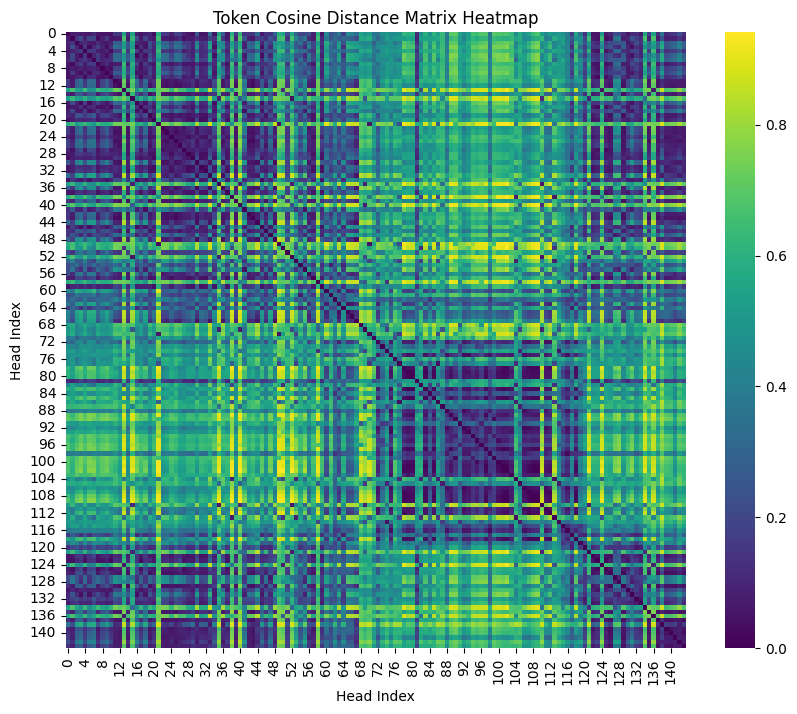

In [ ]:
# 13. 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap='viridis', annot=False) # cmap= ["coolwarm", "viridis", "plasma"] 등이 있음
plt.title("Token Cosine Distance Matrix Heatmap") 
plt.xlabel("Head Index")     # num_layers * num_heads 개수만큼의 Head Index(실제론 layer-head)
plt.ylabel("Head Index")
plt.show()

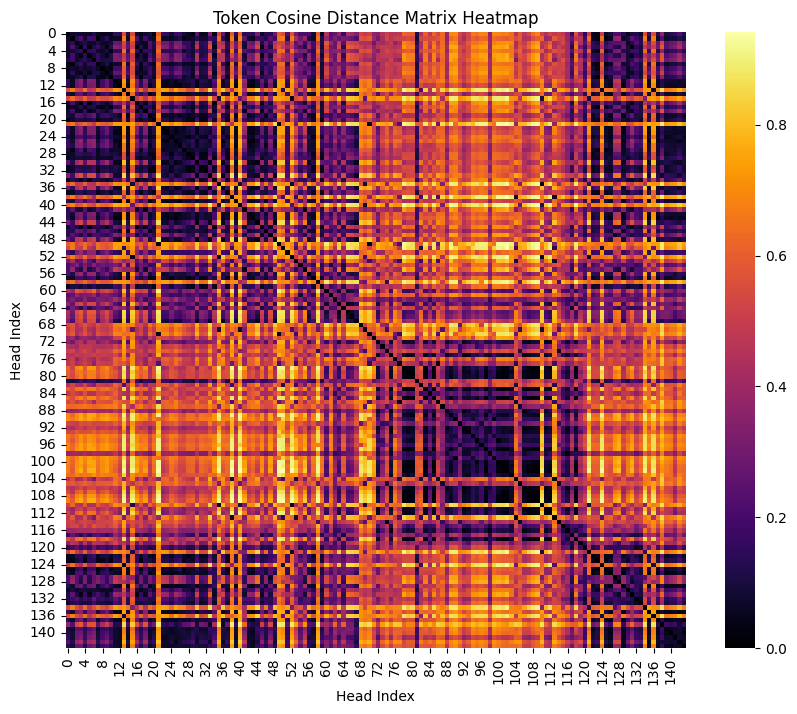

In [14]:
# 13. 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap='inferno', annot=False) # cmap= ["coolwarm", "viridis", "plasma"] 등이 있음
plt.title("Token Cosine Distance Matrix Heatmap") 
plt.xlabel("Head Index")     # num_layers * num_heads 개수만큼의 Head Index(실제론 layer-head)
plt.ylabel("Head Index")
plt.show()

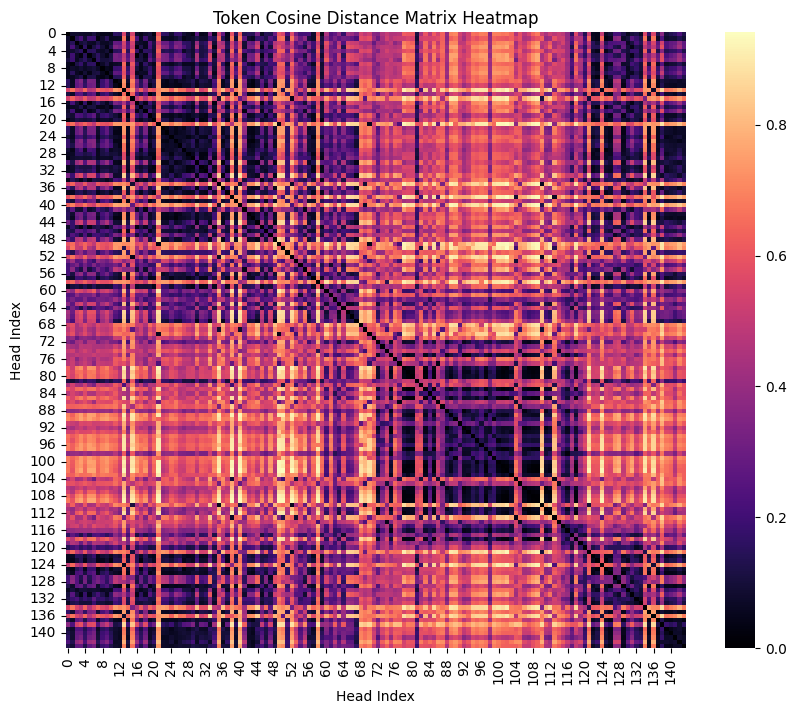

In [15]:
# 13. 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap='magma', annot=False) # cmap= ["coolwarm", "viridis", "plasma"] 등이 있음
plt.title("Token Cosine Distance Matrix Heatmap") 
plt.xlabel("Head Index")     # num_layers * num_heads 개수만큼의 Head Index(실제론 layer-head)
plt.ylabel("Head Index")
plt.show()

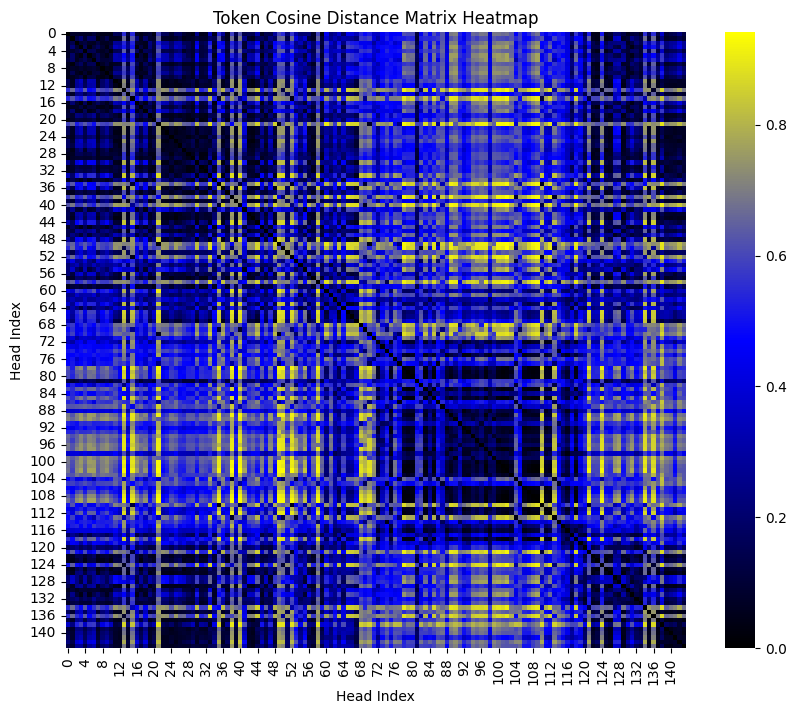

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom", ["black", "blue", "yellow"])

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap=custom_cmap, annot=False) # cmap= ["coolwarm", "viridis", "plasma"] 등이 있음
plt.title("Token Cosine Distance Matrix Heatmap") 
plt.xlabel("Head Index")     # num_layers * num_heads 개수만큼의 Head Index(실제론 layer-head)
plt.ylabel("Head Index")
plt.show()

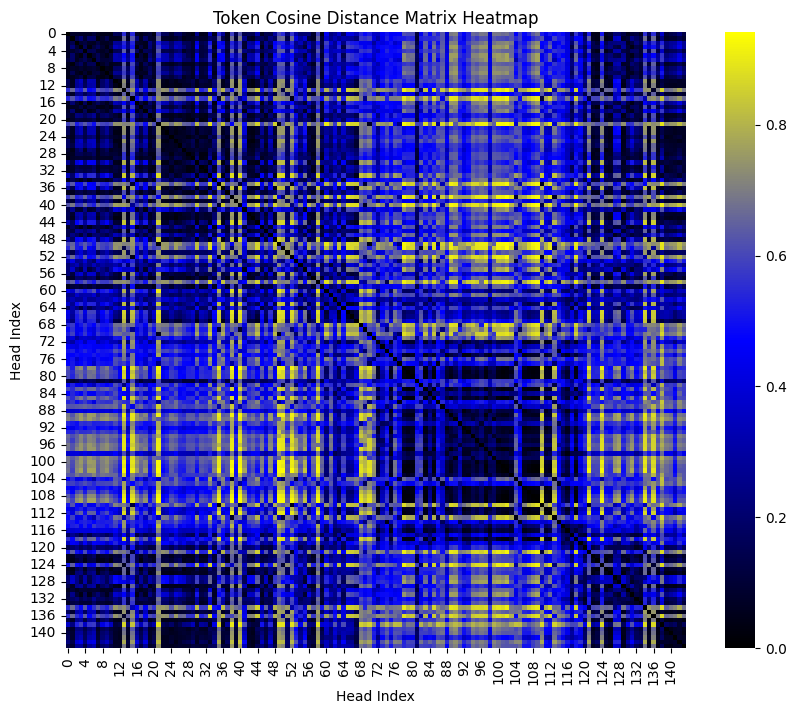

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 사용자 지정 RGB 색상 정의 (검정 -> 어두운 회색 -> 중간 회색 -> 밝은 노랑빛 회색)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom", 
    [(0, 0, 0),       # Black
     (50/255, 50/255, 50/255),   # Dark Gray
     (150/255, 150/255, 150/255),  # Medium Gray
     (230/255, 230/255, 200/255)]  # Light Yellow-Gray
)

# 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

custom_cmap = LinearSegmentedColormap.from_list("custom", ["black", "blue", "yellow"])

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap=custom_cmap, annot=False) # cmap= ["coolwarm", "viridis", "plasma"] 등이 있음
plt.title("Token Cosine Distance Matrix Heatmap") 
plt.xlabel("Head Index")     # num_layers * num_heads 개수만큼의 Head Index(실제론 layer-head)
plt.ylabel("Head Index")
plt.show()

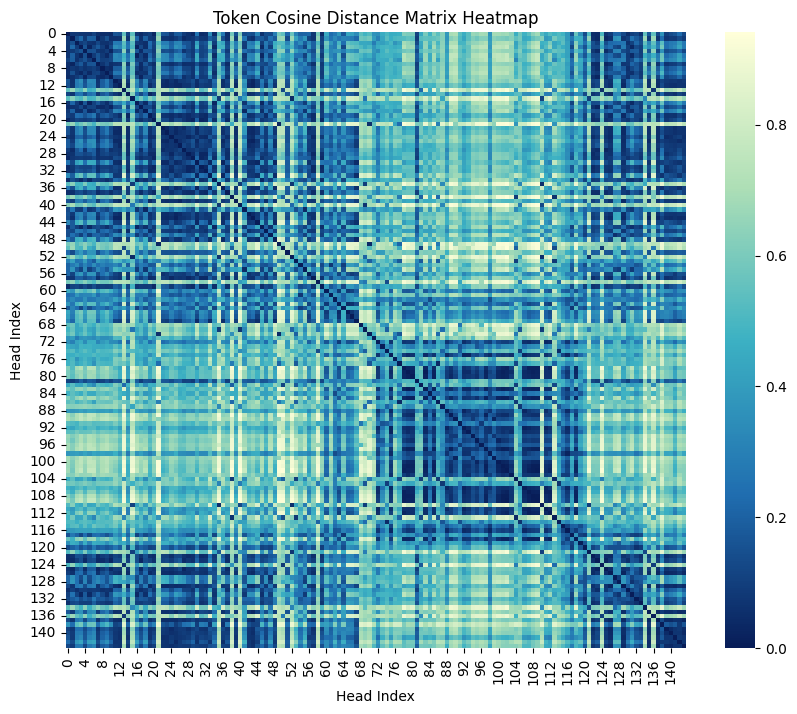

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# 사용자 지정 RGB 색상 정의 (검정 -> 어두운 회색 -> 중간 회색 -> 밝은 노랑빛 회색)
custom_cmap = LinearSegmentedColormap.from_list(
    "custom", 
    [(8/255, 29/255, 88/255),       # Black #081D58
     (32/255,110/255,176/255),   # Dark Gray
     (60/255,177/255,195/255),
     (174/255,223/255,182/255),
     (255/255,255/255,217/255)]  # Light Yellow-Gray
)

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(token_cos_dist_matrix, cmap=custom_cmap, annot=False)
plt.title("Token Cosine Distance Matrix Heatmap") 
plt.xlabel("Head Index")     
plt.ylabel("Head Index")
plt.show()
